In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hubmap-organ-segmentation/sample_submission.csv
/kaggle/input/hubmap-organ-segmentation/train.csv
/kaggle/input/hubmap-organ-segmentation/test.csv
/kaggle/input/hubmap-organ-segmentation/train_images/15329.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/9777.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/686.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/20563.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/23961.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/4301.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/15005.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/2344.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/127.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/5552.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/6021.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/19360.tiff
/kaggle/input/hubmap-organ-segmentation/train_images/15551.tiff
/kaggle/input/hu

# Libraries

In [10]:
import os
import cv2
import glob
import random
import matplotlib
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tifffile as tiff 
from skimage.transform import resize
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds



from skimage.transform import resize

from skimage.color import rgb2gray

import albumentations as A
from tensorflow.keras.applications import EfficientNetB4
import efficientnet.keras as efn

from PIL import Image, ImageOps
from skimage import color



IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

In [5]:
# Data files
RANDOM_SEED = 42 
BASE_DIR = "../input/hubmap-organ-segmentation/"
TRAIN_DIR = "../input/hubmap-organ-segmentation/train_images/"
TEST_DIR = "../input/hubmap-organ-segmentation/test_images/"
LABEL_DIR = "../input/hubmap-organ-segmentation/train_annotations/"

In [6]:
# get list of all subfolders
train_ids = next(os.walk(TRAIN_DIR))[2]
test_ids = next(os.walk(TEST_DIR))[2]

In [7]:
train = pd.read_csv('../input/hubmap-organ-segmentation/train.csv')
test = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')

# Meta Data Analysis

In [16]:
train.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female


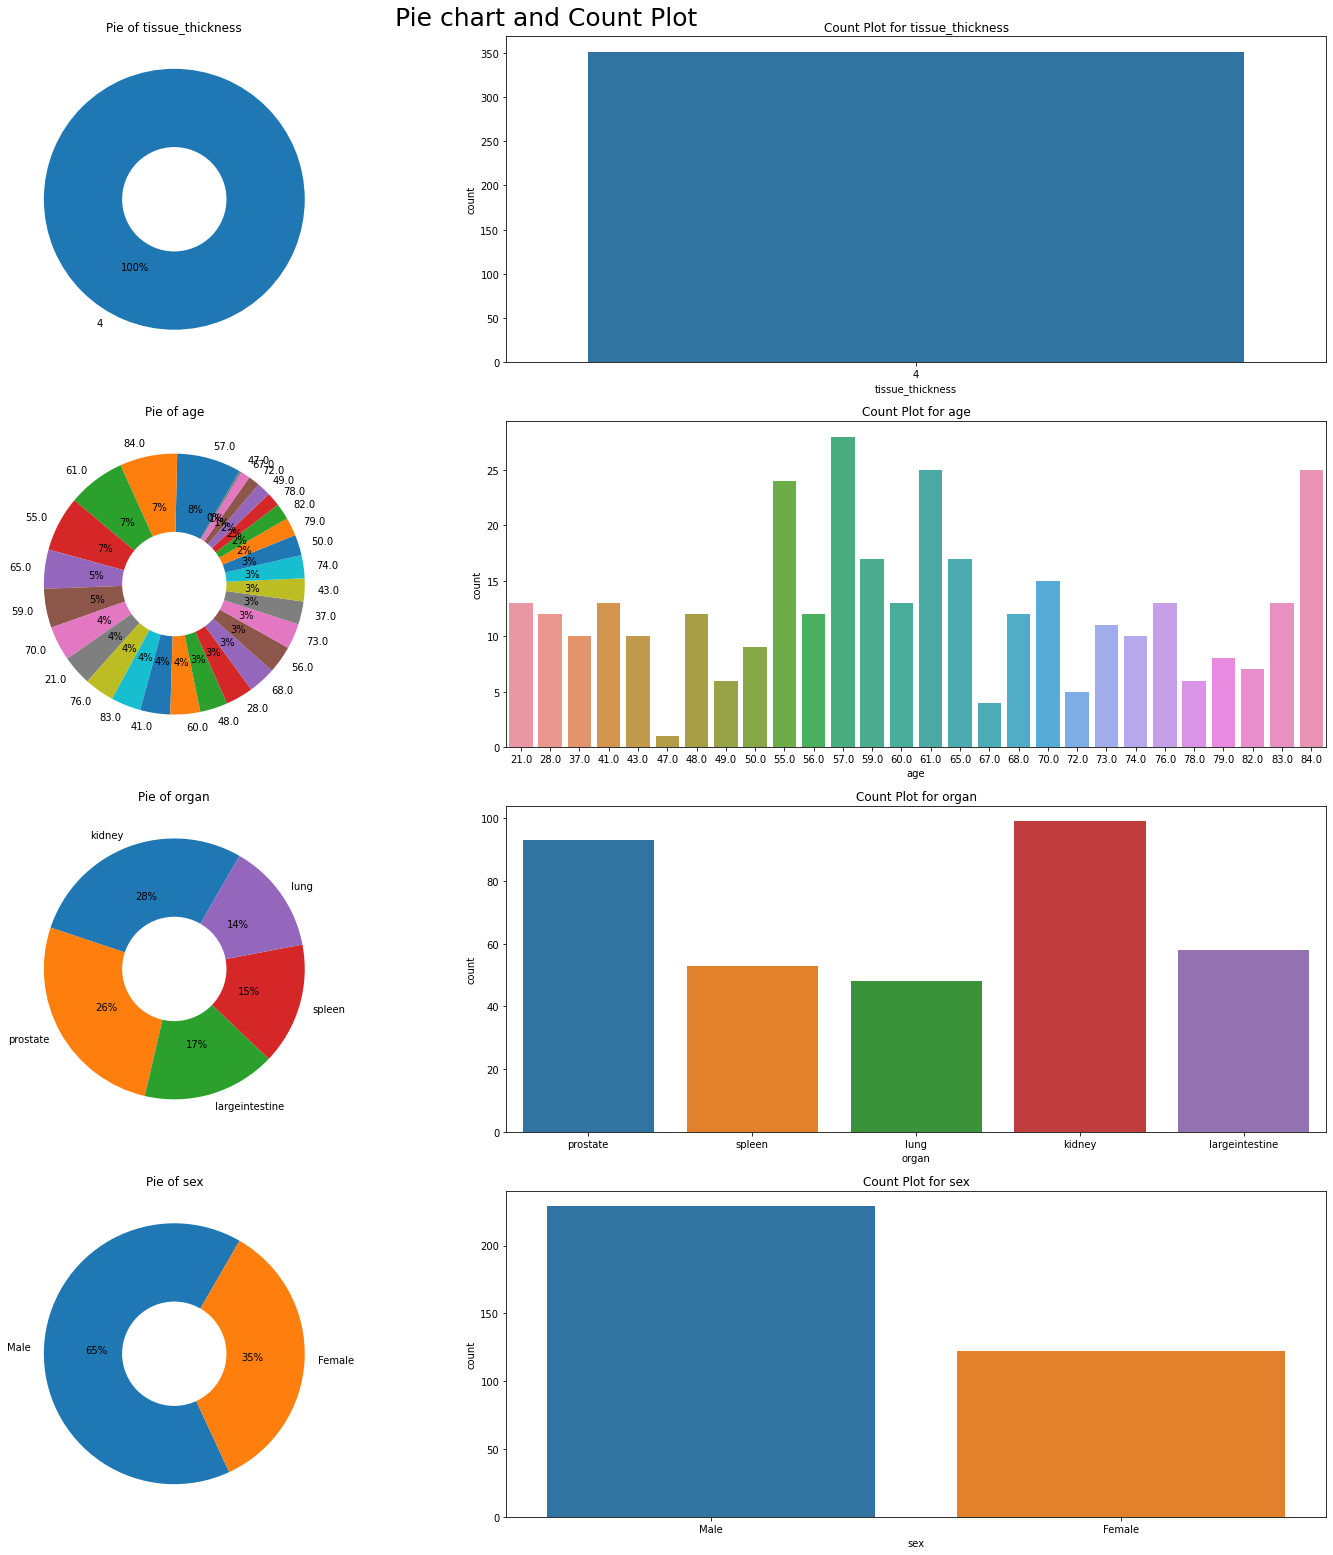

In [13]:
# Train Pie Chart
def pie_count_plot(features,df):
    fig, ax = plt.subplots(4,2,figsize=(22,22))
    for i in enumerate(features):
            fig.suptitle('Pie chart and Count Plot', size = 25)
            ax[i[0],0].title.set_text(f'Pie of {i[1]}')
            labels = list(df[i[1]].value_counts().index)
            values = df[i[1]].value_counts()
            
            ax[i[0],0].pie(values,startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.6)
            ax[i[0],1].title.set_text(f'Count Plot for {i[1]}')
            sns.countplot(x=i[1],data=df ,ax=ax[i[0],1])
            ax[i[0],0].add_artist(plt.Circle((0,0),0.4,fc='white'))
    fig.tight_layout()        
    plt.show()
    
cat_features=['tissue_thickness','age','organ','sex']
pie_count_plot(cat_features,train)

##  Masking and Unmasking Function

In [17]:
def rle2mask(rle, width, target_size=None):
    if target_size == None:
        target_size = width

    rle = np.array(list(map(int, rle.split())))
    label = np.zeros((width*width))
    
    for start, end in zip(rle[::2], rle[1::2]):
        label[start:start+end] = 1
        
    #Convert label to image
    label = Image.fromarray(label.reshape(width, width))
    #Resize label
    label = label.resize((target_size, target_size))
    label = np.array(label).astype(float)
    #rescale label
    label = np.round((label - label.min())/(label.max() - label.min()))
    
    return label.T

def mask2rle(mask, orig_dim=160):
    #Rescale image to original size
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = n.resize((orig_dim, orig_dim))
    n = np.array(n).astype(np.float32)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)